#Arima



## Importación de librerías y datos

Por medio de nuestra libería ESIOS_contoller.py importamos nuestro último dataset de datos y lo parseamos para su uso. Sirve tanto como para Drive como jupiter.

In [1]:
import json, urllib, datetime, pickle, time
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.model_selection import *
from keras.models import *
from keras.layers import *
from sklearn.preprocessing import *
from keras.optimizers import *
from scipy.stats import *
from importlib.machinery import SourceFileLoader


try:
  from google.colab import drive
  drive.mount('/content/drive')
  path = '/content/drive/My Drive/TFM/01.Utils/ESIOS_contoller.py'
  in_colab = True
except:
  path = '../utils/ESIOS_contoller.py'
  in_colab = False
  

esios_assembler = SourceFileLoader('esios', path).load_module()

esios_controller = esios_assembler.ESIOS(in_colab)
data_consumo = esios_controller.get_data('non-secuencial')

Using TensorFlow backend.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Mostrando los datos de data_total_for_non_serial.csv
(30555, 34)
________________________________________________________________________________


## Preparación de los datos

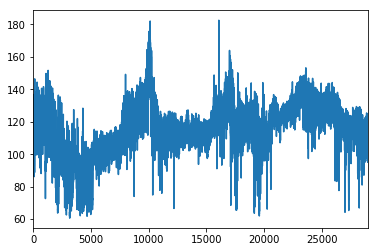

In [54]:
from matplotlib import pyplot
from sklearn.model_selection import train_test_split

data = data_consumo[['date_timestamp', 'PVPC_DEF']]

train, test = train_test_split(data, test_size=0.05, random_state=0, shuffle=False)
train_short, test_short = train_test_split(data, test_size=0.001, random_state=0, shuffle=False)

train['PVPC_DEF'].plot()
pyplot.show()

In [27]:
print(test_short.shape)
print(train.shape)

(31, 1)
(29027, 1)


Viendo esta correlación y las inferiores parece haber correlación entre los datos de **hace un día** y de **hace un año**

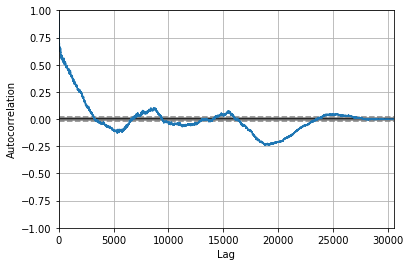

In [44]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(data.PVPC_DEF)
pyplot.show()

## Modelo

In [45]:
from statsmodels.tsa.arima_model import ARIMA
from pandas import DataFrame

model = ARIMA(np.asarray(train.PVPC_DEF), order=(5,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())


                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                29026
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -79670.822
Method:                       css-mle   S.D. of innovations              3.765
Date:                Sat, 31 Aug 2019   AIC                         159355.644
Time:                        09:16:50   BIC                         159413.576
Sample:                             1   HQIC                        159374.261
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.319e-05      0.020     -0.001      0.999      -0.039       0.039
ar.L1.D.y      0.3053      0.006     52.558      0.000       0.294       0.317
ar.L2.D.y     -0.0789      0.006    -13.047      0.0

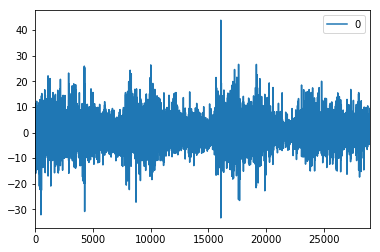

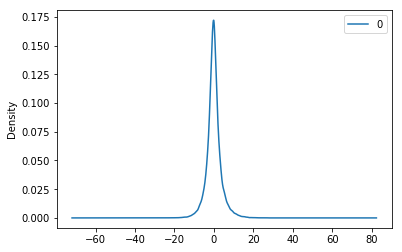

                  0
count  29026.000000
mean       0.000045
std        3.765510
min      -33.344059
25%       -1.752466
50%       -0.127118
75%        1.589554
max       43.837370


In [46]:
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()

print(residuals.describe())

In [47]:
from math import sqrt
from sklearn.metrics import mean_squared_error

#Si hacemos una predicción hora a hora las métricas són de
# SI predecimos sólo el día de mañana hora a hora
# No tiene mucho valor para la muestra, debemos intentar predecir un día entero 


history = train_short.PVPC_DEF.values.tolist()
test_list = test_short.PVPC_DEF.values.tolist()
predictions = list()

print(np.shape(history))
print(history)

for value in test_list:
  model = ARIMA(history, order=(5,1,0))
  model_fit = model.fit(disp=0)
    
  yhat = model_fit.forecast()[0][0]
  predictions.append(yhat)
  history.append(value)
  print(np.shape(history))
  print(history)

Output hidden; open in https://colab.research.google.com to view.

In [48]:
test_list = np.reshape(test_list, (np.shape(test_list)[0]))

def smape_kun(y_true, y_pred):
    rmse = sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(abs((y_true-y_pred)/y_true))*100
    smape = np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) + np.abs(y_true))))
    print('RMSE: %.2f'% (rmse))
    print('MAPE: %.2f %% \nSMAPE: %.2f'% (mape,smape), "%")
    
    
smape_kun(test_list, predictions)


RMSE: 3.13
MAPE: 1.83 % 
SMAPE: 1.83 %


Con el arima normal no es bueno hacer una predicción hora a hora, necesitamos hacer la de un día para eso nos vamos al modelo de SARIMAX más abajo

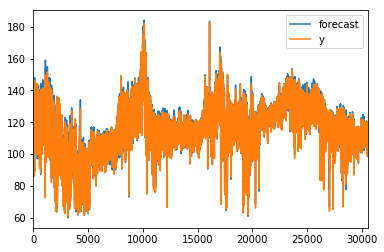

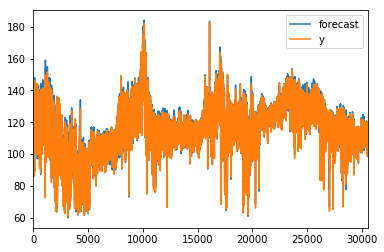

In [49]:
model_fit.plot_predict(dynamic=False)

## Auto Arima


In [0]:
!pip install -q pmdarima
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

model = pm.auto_arima(train.PVPC_DEF, start_p=1, start_q=1, test='adf',max_p=48, max_q=5,m=1, d=None, seasonal=True,  
                      start_P=0, D=0, trace=True,error_action='ignore', suppress_warnings=True, stepwise=True)

print(model.summary())


Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=136514.690, BIC=136547.107, Fit time=8.437 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=206827.213, BIC=206843.421, Fit time=0.690 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=139509.342, BIC=139533.654, Fit time=1.538 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=178831.695, BIC=178856.008, Fit time=6.468 seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=136347.555, BIC=136388.075, Fit time=13.667 seconds
Fit ARIMA: order=(2, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=136454.299, BIC=136486.716, Fit time=1.979 seconds
Fit ARIMA: order=(2, 0, 2) seasonal_order=(0, 0, 0, 1); AIC=136292.873, BIC=136341.498, Fit time=33.528 seconds
Fit ARIMA: order=(3, 0, 3) seasonal_order=(0, 0, 0, 1); AIC=137437.157, BIC=137501.990, Fit time=56.535 seconds
Fit ARIMA: order=(1, 0, 2) seasonal_order=(0, 0, 0, 1); AIC=136291.549, BIC=136332.069, Fit time=12.395 secon

In [0]:
model.plot_diagnostics(figsize=(7,5))
plt.show()

##  Try best model

In [58]:
import statsmodels.api as sm

mod = sm.tsa.statespace.SARIMAX(train.PVPC_DEF, order=(4, 0, 5))
res = mod.fit(disp=False)
print(res.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                           Statespace Model Results                           
Dep. Variable:               PVPC_DEF   No. Observations:                29027
Model:               SARIMAX(4, 0, 5)   Log Likelihood              -78414.047
Date:                Sat, 31 Aug 2019   AIC                         156848.094
Time:                        09:26:00   BIC                         156930.854
Sample:                             0   HQIC                        156874.691
                              - 29027                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          3.4988      0.006    603.587      0.000       3.487       3.510
ar.L2         -4.8366      0.015   -312.662      0.000      -4.867      -4.806
ar.L3          3.1237      0.015    205.392      0.0

NormaltestResult(statistic=14759.06255915423, pvalue=0.0)


Text(0.5, 1.0, 'Residual distribution')

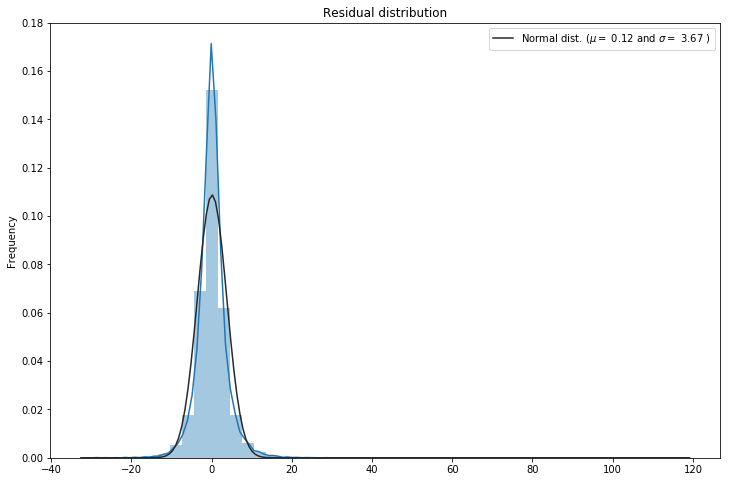

In [25]:
from scipy import stats
from scipy.stats import normaltest

resid = res.resid
print(normaltest(resid))
# returns a 2-tuple of the chi-squared statistic, and the associated p-value. the p-value is very small, meaning
# the residual is not a normal distribution

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(resid ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(resid)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')

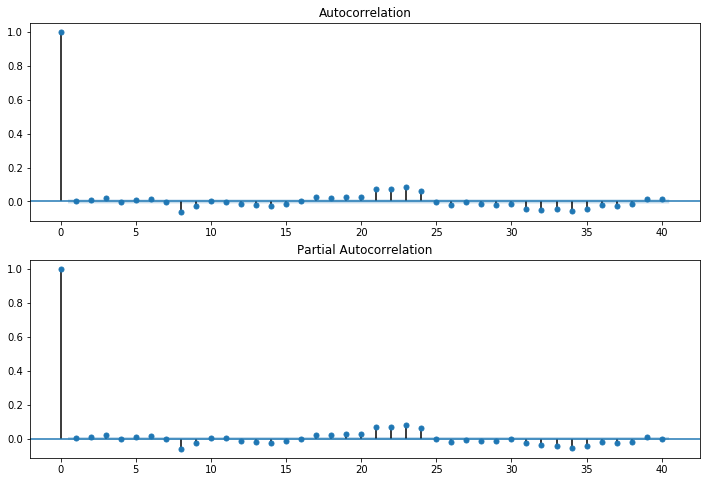

In [26]:
# ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(res.resid, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(res.resid, lags=40, ax=ax2)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


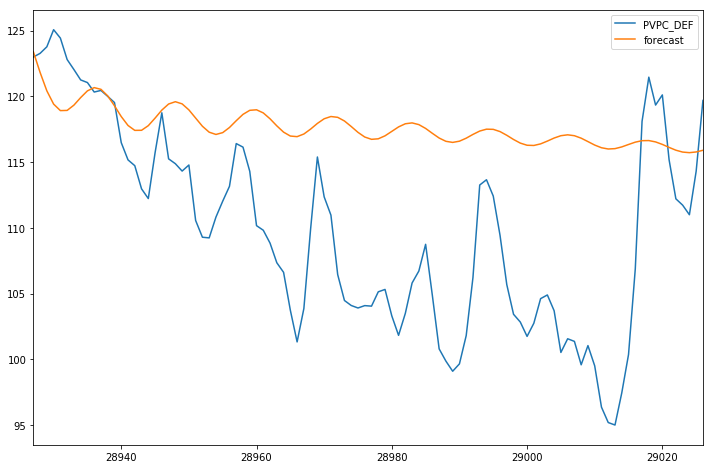

In [55]:
start_index = 28927
end_index = 29027
train_validation = train
train_validation['forecast'] = res.predict(start = start_index, end= end_index, dynamic= True)  
train_validation[start_index:end_index][['PVPC_DEF', 'forecast']].plot(figsize=(12, 8))



In [63]:
#PREDICCIÓN DÍA A DÍA
## !!!

history = train.PVPC_DEF
predictions = list()
predictions_reals = list()

for i in range(0, len(test), 24):
  mod = sm.tsa.statespace.SARIMAX(history, order=(4, 0, 5))
  res = mod.fit(disp=False)
  
  end_index = np.shape(history)[0]
  start_index = end_index - 23
  
  y_preds = res.predict(start = start_index, end= end_index, dynamic= True) 
  print(np.shape(y_preds))
  predictions.append(y_preds)
  y_reals = test.iloc[i : i + 24]
  y_reals = y_reals.PVPC_DEF
  print(np.shape(y_reals))
  predictions_reals.append(y_reals)
  
  history.append(y_reals)


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(24,)
(24,)


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(24,)
(24,)


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(24,)
(24,)


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(24,)
(24,)


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(24,)
(24,)


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(24,)
(24,)


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(24,)
(24,)


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(24,)
(24,)


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(24,)
(24,)


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(24,)
(24,)


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(24,)
(24,)


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(24,)
(24,)


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(24,)
(24,)


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(24,)
(24,)


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(24,)
(24,)


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(24,)
(24,)


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(24,)
(24,)


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(24,)
(24,)


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(24,)
(24,)


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(24,)
(24,)


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(24,)
(24,)


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(24,)
(24,)


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(24,)
(24,)


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(24,)
(24,)


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(24,)
(24,)


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(24,)
(24,)


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(24,)
(24,)


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(24,)
(24,)


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(24,)
(24,)


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(24,)
(24,)


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(24,)
(24,)


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(24,)
(24,)


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(24,)
(24,)


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(24,)
(24,)


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(24,)
(24,)


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(24,)
(24,)


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(24,)
(24,)


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(24,)
(24,)


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(24,)
(24,)


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(24,)
(24,)


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(24,)
(24,)


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(24,)
(24,)


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(24,)
(24,)


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(24,)
(24,)


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(24,)
(24,)


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(24,)
(24,)


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(24,)
(24,)


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(24,)
(24,)


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(24,)
(24,)


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(24,)
(24,)


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(24,)
(24,)


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(24,)
(24,)


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(24,)
(24,)


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(24,)
(24,)


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(24,)
(24,)


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(24,)
(24,)


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(24,)
(24,)


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(24,)
(24,)


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(24,)
(24,)


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(24,)
(24,)


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(24,)
(24,)


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(24,)
(24,)


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(24,)
(24,)


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(24,)
(16,)


In [93]:
predictions_real_res = []
for x in predictions_reals:
  predictions_real_res.extend(x.values)
  
print(np.shape(predictions_real_res)) 

(1528,)


In [95]:
predictions_res = np.reshape(predictions, (64*24))
predictions_res = predictions_res[:1528]

print(np.shape(predictions_res))

(1528,)


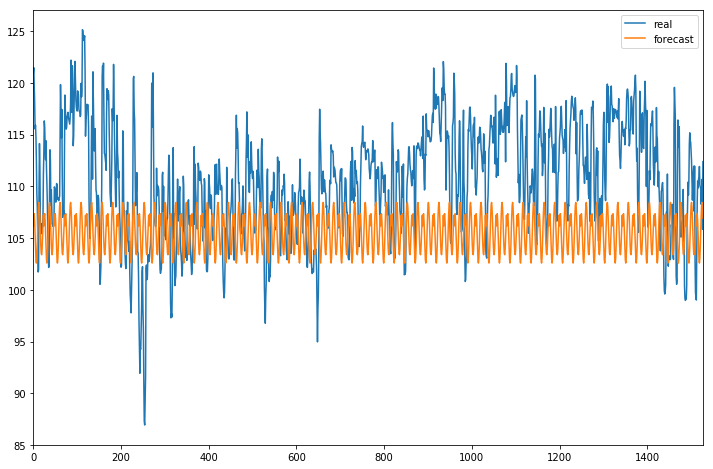

In [97]:
d = {'real':predictions_real_res,'forecast':predictions_res}
df = pd.DataFrame(d)
df.plot(figsize=(12, 8))

In [98]:
test_list = np.reshape(test_list, (np.shape(test_list)[0]))

def smape_kun(y_true, y_pred):
    rmse = sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(abs((y_true-y_pred)/y_true))*100
    smape = np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) + np.abs(y_true))))
    print('RMSE: %.2f'% (rmse))
    print('MAPE: %.2f %% \nSMAPE: %.2f'% (mape,smape), "%")
    
    
smape_kun(predictions_real_res, predictions_res)

RMSE: 7.75
MAPE: 5.75 % 
SMAPE: 5.94 %
